### Feature importance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint  
import h5py

%matplotlib inline

Using TensorFlow backend.


In [2]:
con = sqlite3.connect('brfss.sqlite')

### Using 1 year data (2013)

In [71]:
q = '''
select MENTHLTH, GENHLTH, MARITAL, EDUCA, EMPLOY1 as employ, INCOME2, SEX, [x.RFSMOK3] as smoking, [x.RFBING5] as drinking, 
[x.TOTINDA] as pactivity, [x.RACEGR3] as race, [x.AGEG5YR] as age, HLTHPLN1 as hlthplan, [x.RFBMI5] as obese, [x.BMI5] as bmi,
CHILDREN, PHYSHLTH
from BRFSS_2013
where (MENTHLTH between 1 and 30 or MENTHLTH=88)
and (GENHLTH between 1 and 5)
and (MARITAL between 1 and 6)
and (EDUCA between 1 and 6)
and (EMPLOY1 between 1 and 8)
and (INCOME2 between 1 and 8)
and (SEX between 1 and 2)
and ([x.RFSMOK3] between 1 and 2)
and ([x.RFBING5] between 1 and 2)
and ([x.TOTINDA] between 1 and 2)
and ([x.RACEGR3] between 1 and 5)
and ([x.AGEG5YR] between 1 and 13)
and (HLTHPLN1 between 1 and 2)
and ([x.RFBMI5] between 1 and 2)
and ([x.BMI5] between 1 and 9999)
and (CHILDREN between 1 and 88)
and (PHYSHLTH between 1 and 30 or PHYSHLTH=88)
'''

In [72]:
df = pd.read_sql(q, con)

In [73]:
df.shape

(356311, 17)

In [74]:
df.head()

,menthlth,genhlth,marital,educa,employ,income2,sex,smoking,drinking,pactivity,race,age,hlthplan,obese,bmi,children,physhlth
0,29,4,2,6,7,7,2,1,1,2,2,9,1,2,3916,88,30
1,88,3,1,5,1,8,2,1,1,1,1,7,1,1,1822,2,88
2,2,3,1,6,1,8,2,2,2,2,1,8,1,2,2746,88,3
3,88,2,1,4,7,7,2,1,1,1,1,9,1,1,2197,88,2
4,2,3,1,6,7,6,1,1,1,2,1,10,1,2,3594,88,10


In [75]:
df.menthlth = df.apply(lambda row: 0 if row.menthlth==88 else 1, axis=1)

df.pactivity = df.apply(lambda row: 0 if row.pactivity==2 else 1, axis=1)
df.sex = df.apply(lambda row: 0 if row.sex==2 else 1, axis=1)
df.hlthplan = df.apply(lambda row: 0 if row.hlthplan==2 else 1, axis=1)

df.smoking = df.apply(lambda row: 1 if row.smoking==2 else 0, axis=1)
df.drinking = df.apply(lambda row: 1 if row.drinking==2 else 0, axis=1)
df.obese = df.apply(lambda row: 1 if row.obese==2 else 0, axis=1)

df.children = df.apply(lambda row: 0 if row.children==88 else row.children, axis=1)
df.physhlth = df.apply(lambda row: 0 if row.physhlth==88 else row.physhlth, axis=1)

In [76]:
cat_features = ['marital', 'employ', 'race']

df = pd.get_dummies(df, columns=cat_features, drop_first=False)

In [77]:
df.head()

,menthlth,genhlth,educa,income2,sex,smoking,drinking,pactivity,age,hlthplan,...,employ_4,employ_5,employ_6,employ_7,employ_8,race_1,race_2,race_3,race_4,race_5
0,1,4,6,7,0,0,0,0,9,1,...,0,0,0,1,0,0,1,0,0,0
1,0,3,5,8,0,0,0,1,7,1,...,0,0,0,0,0,1,0,0,0,0
2,1,3,6,8,0,1,1,0,8,1,...,0,0,0,0,0,1,0,0,0,0
3,0,2,4,7,0,0,0,1,9,1,...,0,0,0,1,0,1,0,0,0,0
4,1,3,6,6,1,0,0,0,10,1,...,0,0,0,1,0,1,0,0,0,0


In [78]:
y = df.menthlth
x = df[df.columns[1:]]
print(x.shape, y.shape)

(356311, 32) (356311,)


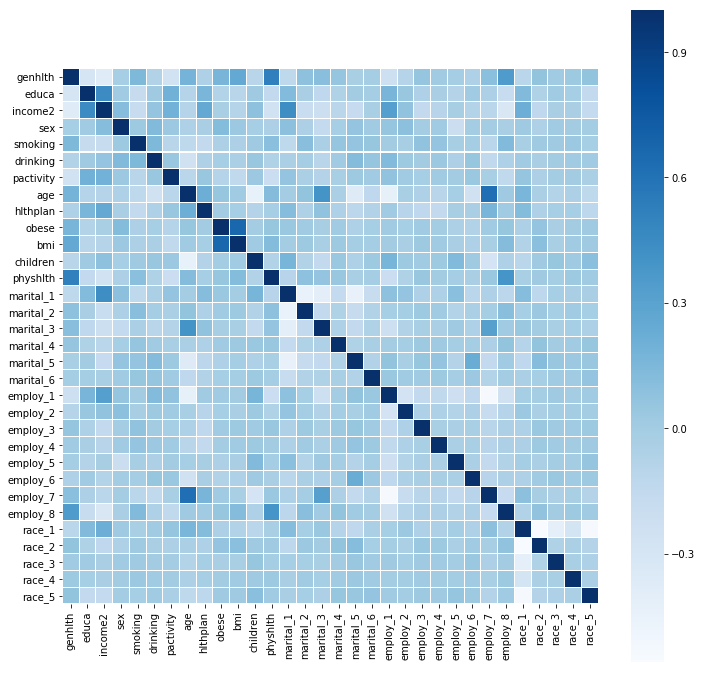

In [79]:
plt.figure(figsize=(12,12))
sns.heatmap(x.corr(), square=True, annot=False, linewidths=0.01, cmap='Blues')

In [80]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1, shuffle=True)
model = RandomForestClassifier(n_estimators=250, random_state=1, n_jobs=-1, max_depth=15)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [81]:
pred = model.predict(x_test)
accuracy_score(y_test, pred)

0.7304632137294248

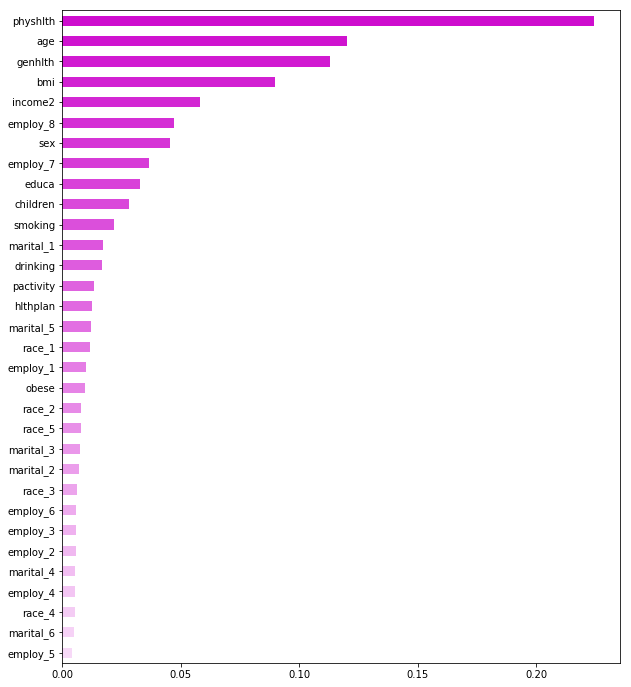

In [82]:
alphas = np.linspace(0.95, 0.15, 32)
rgba_colors = np.zeros((32, 4))
# for red the first column needs to be one
rgba_colors[:, 2] = 0.8
rgba_colors[:, 1] = 0.
rgba_colors[:, 0] = 0.8
# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphas

plt.figure(figsize=(10, 12))
pd.Series(model.feature_importances_, index=x.columns).nlargest(32).plot(kind='barh', color=rgba_colors)
plt.gca().invert_yaxis()

In [83]:
model = GradientBoostingClassifier(random_state=1, n_estimators=300, n_iter_no_change=10)
model.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=10, presort='auto', random_state=1,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [84]:
pred = model.predict(x_test)
accuracy_score(y_test, pred)

0.7320067917432609

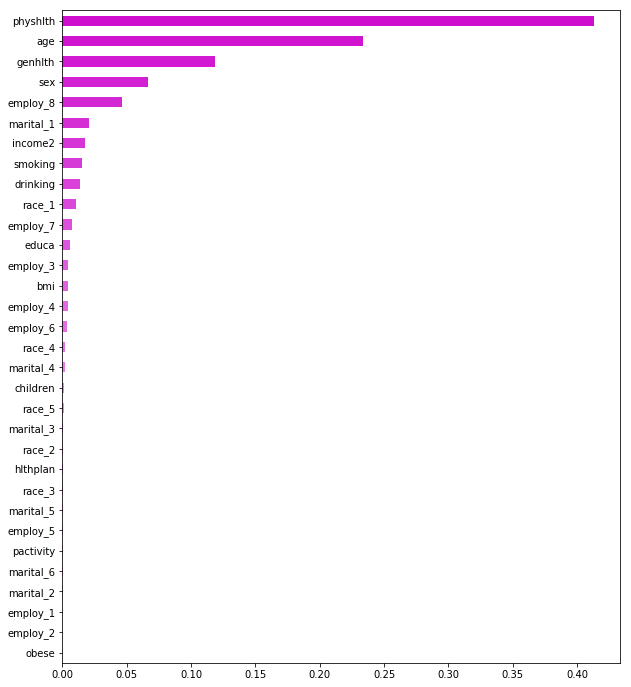

In [85]:
alphas = np.linspace(0.95, 0.15, 32)
rgba_colors = np.zeros((32, 4))
# for red the first column needs to be one
rgba_colors[:, 2] = 0.8
rgba_colors[:, 1] = 0.
rgba_colors[:, 0] = 0.8
# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphas

plt.figure(figsize=(10, 12))
pd.Series(model.feature_importances_, index=x.columns).nlargest(32).plot(kind='barh', color=rgba_colors)
plt.gca().invert_yaxis()

### Using 11 years data

In [3]:
tables = [
    'BRFSS_2007',
    'BRFSS_2008',
    'BRFSS_2009',
    'BRFSS_2010',
    'BRFSS_2011',
    'BRFSS_2012',
    'BRFSS_2013',
    'BRFSS_2014',
    'BRFSS_2015',
    'BRFSS_2016',
    'BRFSS_2017'
]

dfs = {}

for table in tables[6:]:
    
    q = '''
        select MENTHLTH, GENHLTH, MARITAL, EDUCA, EMPLOY1 as employ, INCOME2, SEX, [x.RFSMOK3] as smoking, 
        [x.RFBING5] as drinking, [x.TOTINDA] as pactivity, [x.RACEGR3] as race, [x.AGEG5YR] as age, 
        HLTHPLN1 as hlthplan, [x.RFBMI5] as obese, [x.BMI5] as bmi, CHILDREN, PHYSHLTH
        from {}
        where (MENTHLTH between 1 and 30 or MENTHLTH=88)
        and (GENHLTH between 1 and 5)
        and (MARITAL between 1 and 6)
        and (EDUCA between 1 and 6)
        and (EMPLOY1 between 1 and 8)
        and (INCOME2 between 1 and 8)
        and (SEX between 1 and 2)
        and ([x.RFSMOK3] between 1 and 2)
        and ([x.RFBING5] between 1 and 2)
        and ([x.TOTINDA] between 1 and 2)
        and ([x.RACEGR3] between 1 and 5)
        and ([x.AGEG5YR] between 1 and 13)
        and (HLTHPLN1 between 1 and 2)
        and ([x.RFBMI5] between 1 and 2)
        and ([x.BMI5] between 1 and 9999)
        and (CHILDREN between 1 and 88)
        and (PHYSHLTH between 1 and 30 or PHYSHLTH=88)
        '''.format(table)
    
    df = pd.read_sql(q, con)
    dfs[table] = df
    
for table in tables[4:6]:
    
    q = '''
        select MENTHLTH, GENHLTH, MARITAL, EDUCA, EMPLOY, INCOME2, SEX, [x.RFSMOK3] as smoking, 
        [x.RFBING5] as drinking, [x.TOTINDA] as pactivity, [x.RACEGR2] as race, [x.AGEG5YR] as age, 
        HLTHPLN1 as hlthplan, [x.RFBMI5] as obese, [x.BMI5] as bmi, CHILDREN, PHYSHLTH
        from {}
        where (MENTHLTH between 1 and 30 or MENTHLTH=88)
        and (GENHLTH between 1 and 5)
        and (MARITAL between 1 and 6)
        and (EDUCA between 1 and 6)
        and (EMPLOY between 1 and 8)
        and (INCOME2 between 1 and 8)
        and (SEX between 1 and 2)
        and ([x.RFSMOK3] between 1 and 2)
        and ([x.RFBING5] between 1 and 2)
        and ([x.TOTINDA] between 1 and 2)
        and ([x.RACEGR2] between 1 and 5)
        and ([x.AGEG5YR] between 1 and 13)
        and (HLTHPLN1 between 1 and 2)
        and ([x.RFBMI5] between 1 and 2)
        and ([x.BMI5] between 1 and 9999)
        and (CHILDREN between 1 and 88)
        and (PHYSHLTH between 1 and 30 or PHYSHLTH=88)
        '''.format(table)

    df = pd.read_sql(q, con)
    dfs[table] = df
    
for table in tables[:4]:
    
    q = '''
        select MENTHLTH, GENHLTH, MARITAL, EDUCA, EMPLOY, INCOME2, SEX, [x.RFSMOK3] as smoking, 
        [x.RFBING4] as drinking, [x.TOTINDA] as pactivity, [x.RACEGR2] as race, [x.AGEG5YR] as age, 
        HLTHPLAN as hlthplan, [x.RFBMI4] as obese, [x.BMI4] as bmi, CHILDREN, PHYSHLTH
        from {}
        where (MENTHLTH between 1 and 30 or MENTHLTH=88)
        and (GENHLTH between 1 and 5)
        and (MARITAL between 1 and 6)
        and (EDUCA between 1 and 6)
        and (EMPLOY between 1 and 8)
        and (INCOME2 between 1 and 8)
        and (SEX between 1 and 2)
        and ([x.RFSMOK3] between 1 and 2)
        and ([x.RFBING4] between 1 and 2)
        and ([x.TOTINDA] between 1 and 2)
        and ([x.RACEGR2] between 1 and 5)
        and ([x.AGEG5YR] between 1 and 13)
        and (HLTHPLAN between 1 and 2)
        and ([x.RFBMI4] between 1 and 2)
        and ([x.BMI4] between 1 and 9998)
        and (CHILDREN between 1 and 88)
        and (PHYSHLTH between 1 and 30 or PHYSHLTH=88)
        '''.format(table)

    df = pd.read_sql(q, con)
    dfs[table] = df
    
    

In [4]:
data = pd.DataFrame()

for table in tables:
    df = dfs[table]
    data = pd.concat([data, df], ignore_index=True)

In [5]:
data.shape

(3754830, 17)

In [6]:
def preprocess(df):

    df.menthlth = df.apply(lambda row: 0 if row.menthlth==88 else 1, axis=1)

    df.pactivity = df.apply(lambda row: 0 if row.pactivity==2 else 1, axis=1)
    df.sex = df.apply(lambda row: 0 if row.sex==2 else 1, axis=1)
    df.hlthplan = df.apply(lambda row: 0 if row.hlthplan==2 else 1, axis=1)

    df.smoking = df.apply(lambda row: 1 if row.smoking==2 else 0, axis=1)
    df.drinking = df.apply(lambda row: 1 if row.drinking==2 else 0, axis=1)
    df.obese = df.apply(lambda row: 1 if row.obese==2 else 0, axis=1)

    df.children = df.apply(lambda row: 0 if row.children==88 else row.children, axis=1)
    df.physhlth = df.apply(lambda row: 0 if row.physhlth==88 else row.physhlth, axis=1)

    cat_features = ['marital', 'employ', 'race']

    df = pd.get_dummies(df, columns=cat_features, drop_first=False)
    
    return df

In [7]:
data = preprocess(data)

In [8]:
y = data.menthlth
x = data[data.columns[1:]]
print(x.shape, y.shape) 

(3754830, 32) (3754830,)


### Use historical data (2007 ~ 2016) to predict future (2017)

In [9]:
dfs['BRFSS_2017'].shape

(315405, 17)

In [10]:
x_test = x.iloc[-315405:,]
y_test = y[-315405:]
x_train = x.iloc[:3439425,]
y_train = y[:3439425]
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3439425, 32) (315405, 32) (3439425,) (315405,)


In [94]:
model = RandomForestClassifier(n_estimators=250, random_state=1, n_jobs=-1, max_depth=15)

In [95]:
%%time

model.fit(x_train, y_train)

CPU times: user 32min 2s, sys: 8.3 s, total: 32min 10s
Wall time: 32min 10s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [96]:
pred = model.predict(x_test)

In [97]:
accuracy_score(y_test, pred)

0.7244653699212124

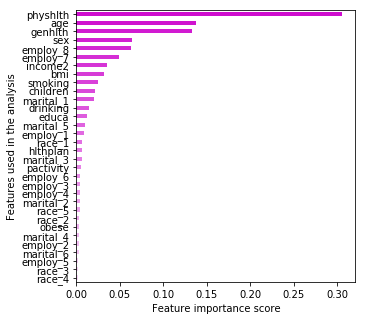

In [98]:
alphas = np.linspace(0.95, 0.15, 32)
rgba_colors = np.zeros((32, 4))
# for red the first column needs to be one
rgba_colors[:, 2] = 0.8
rgba_colors[:, 1] = 0.
rgba_colors[:, 0] = 0.8
# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphas

plt.figure(figsize=(5, 5))
pd.Series(model.feature_importances_, index=x.columns).nlargest(32).plot(kind='barh', color=rgba_colors)
plt.gca().invert_yaxis()

plt.ylabel('Features used in the analysis')
plt.xlabel('Feature importance score')

plt.savefig('featureImportance2.pdf')

In [31]:
model = GradientBoostingClassifier(random_state=1, n_estimators=300, n_iter_no_change=10)

In [32]:
%%time

model.fit(x_train, y_train)

CPU times: user 25min 35s, sys: 0 ns, total: 25min 35s
Wall time: 25min 35s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=10, presort='auto', random_state=1,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [33]:
pred = model.predict(x_test)

In [34]:
accuracy_score(y_test, pred)

0.7270747134636419

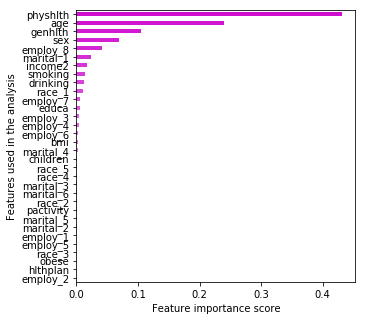

In [35]:
alphas = np.linspace(0.95, 0.15, 32)
rgba_colors = np.zeros((32, 4))
# for red the first column needs to be one
rgba_colors[:, 2] = 0.8
rgba_colors[:, 1] = 0.
rgba_colors[:, 0] = 0.8
# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphas

plt.figure(figsize=(5, 5))
pd.Series(model.feature_importances_, index=x.columns).nlargest(32).plot(kind='barh', color=rgba_colors)
plt.gca().invert_yaxis()

plt.ylabel('Features used in the analysis')
plt.xlabel('Feature importance score')

plt.savefig('featureImportance2.pdf', bbox_inches='tight')

### Taking logarithm on skewed feature (BMI), MinMax Scaling, PCA, Keras

In [11]:
x_test = x.iloc[-315405:,]
y_test = y[-315405:]
x_train = x.iloc[:3439425,]
y_train = y[:3439425]
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3439425, 32) (315405, 32) (3439425,) (315405,)


In [12]:
x.bmi.describe()

count    3.754830e+06
mean     2.795017e+03
std      6.128758e+02
min      6.430000e+02
25%      2.378000e+03
50%      2.695000e+03
75%      3.090000e+03
max      9.998000e+03
Name: bmi, dtype: float64

In [13]:
x_train.loc[:,'bmi'] = np.log(x_train.loc[:,'bmi'])
x_test.loc[:,'bmi'] = np.log(x_test.loc[:,'bmi'])

/home/hadi/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [14]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

/home/hadi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [15]:
# print cumulated explained_variance_ratio

def print_var(pca):
    print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

In [17]:
pca = PCA(n_components=24, random_state=1)
x_train_pca = pca.fit_transform(x_train)
print_var(pca)

[14.86 26.56 35.66 43.34 50.06 56.41 61.62 66.14 70.23 73.83 77.12 80.21
 83.01 85.31 87.42 89.18 90.72 92.18 93.35 94.45 95.43 96.32 97.14 97.91]


In [18]:
x_test_pca = pca.transform(x_test)

In [19]:
# break training set into training and validation sets
x_train_mlp, x_valid_mlp, y_train_mlp, y_valid_mlp = train_test_split(x_train_pca, y_train, test_size=0.2, random_state=1)

# print number of training, validation, and test samples
print(x_train_mlp.shape[0], 'Train samples')
print(x_valid_mlp.shape[0], 'Validation samples')
print(x_test_pca.shape[0], 'Test samples')

2751540 Train samples
687885 Validation samples
315405 Test samples


In [20]:
np.random.seed(1)

model = Sequential()

model.add(Dense(200, input_dim=24, use_bias=True, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(100, use_bias=True, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(32, use_bias=True, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1, use_bias=True, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               5000      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 28,365
Trainable params: 28,365
Non-trainable params: 0
_________________________________________________________________


In [21]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# train the model
checkpointer = ModelCheckpoint(filepath='BRFSS.weights.best.hdf5', verbose=1, save_best_only=True)
model.fit(x_train_mlp, y_train_mlp, epochs=15, validation_data=(x_valid_mlp, y_valid_mlp), 
          callbacks=[checkpointer], verbose=2, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 2751540 samples, validate on 687885 samples
Epoch 1/15
 - 133s - loss: 0.5487 - acc: 0.7261 - val_loss: 0.5476 - val_acc: 0.7273

Epoch 00001: val_loss improved from inf to 0.54758, saving model to BRFSS.weights.best.hdf5
Epoch 2/15
 - 126s - loss: 0.5460 - acc: 0.7281 - val_loss: 0.5456 - val_acc: 0.7284

Epoch 00002: val_loss improved from 0.54758 to 0.54563, saving model to BRFSS.weights.best.hdf5
Epoch 3/15
 - 128s - loss: 0.5454 - acc: 0.7286 - val_loss: 0.5454 - val_acc: 0.7285

Epoch 00003: val_loss improved from 0.54563 to 0.54535, saving model to BRFSS.weights.best.hdf5
Epoch 4/15
 - 117s - loss: 0.5451 - acc: 0.7287 - val_loss: 0.5459 - val_acc: 0.7286

Epoch 00004: val_loss did not improve from 0.54535
Epoch 5/15
 - 109s - loss: 0.5448 - acc: 0.7290 - val_loss: 0.5452 - val_acc: 0.7287

Epoch 00005: val_loss improved from 0.54535 to 0.54525, saving model to BRFSS.weights.best.hdf5
Epoch 6/15
 - 111s - loss: 0.5446 - ac

In [23]:
# load the weights that yielded the best validation accuracy
model.load_weights('BRFSS.weights.best.hdf5')

In [24]:
# evaluate and print train accuracy
score = model.evaluate(x_train_pca, y_train, verbose=0)
print('Train accuracy:', score[1])

Train accuracy: 0.7297871010415985


In [25]:
# evaluate and print test accuracy
score = model.evaluate(x_test_pca, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.7268274123751329


In [26]:
preds = model.predict_classes(x_test_pca, verbose=0)

In [27]:
cm = confusion_matrix(y_test, preds)

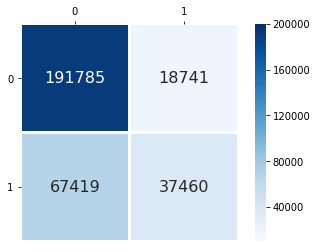

In [28]:
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='.0f', cmap="Blues", linewidth=2, 
                 square=True, vmin=10000, vmax=200000, cbar=True)
plt.yticks(rotation=0)
ax.xaxis.tick_top()

In [29]:
from sklearn.metrics import roc_curve, auc

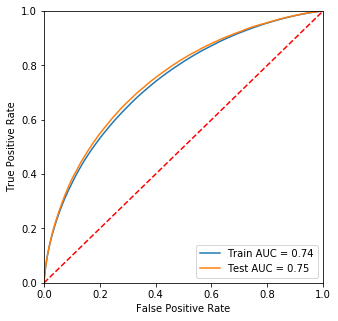

In [30]:
preds_train = model.predict_proba(x_train_pca)
fpr_train, tpr_train, threshold_train = roc_curve(y_train, preds_train)
roc_auc_train = auc(fpr_train, tpr_train)

preds_test = model.predict_proba(x_test_pca)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, preds_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(5, 5))
#plt.title('ROC Curve')
plt.plot(fpr_train, tpr_train, label = 'Train AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, label = 'Test AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC.pdf', bbox_inches='tight')